<a href="https://colab.research.google.com/github/Alpostros/MachineLearning/blob/master/Cat_vs_Dog_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install -q kaggle
from google.colab import files
files.upload()

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

In [0]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import random
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
warnings.filterwarnings('ignore')

In [0]:
from zipfile import ZipFile
with ZipFile('train.zip', 'r') as zipObj:
   zipObj.extractall()

with ZipFile('test.zip', 'r') as zipObj:
   zipObj.extractall()

In [0]:
img_width = 150
img_height = 150
TRAIN_DIR = '/content/train/'
TEST_DIR = '/content/test/'
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
random.shuffle(train_images)
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [0]:
def prep_images(list_of_images):
    x = [] #images
    y = [] #labels
    
    for image in list_of_images:
        x.append(cv2.resize(cv2.imread(image), (img_width,img_height), interpolation=cv2.INTER_CUBIC))
    
    for i in list_of_images:
        if 'dog' in i:
            y.append(1)
        elif 'cat' in i:
            y.append(0)
            
    return x, y

In [0]:
#train_images = train_images[:5000]

In [0]:
X, Y = prep_images(train_images)

In [0]:
print(len(train_images))
del train_images # freeing up memory

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=101)
del X, Y # freeing up memory

In [0]:
def plot_data(X, y, num_figures):
    plt.figure(figsize=(30, 20))
    for i in range(num_figures):
        plt.subplot(2, num_figures, i+1)
        plt.imshow(X[i])
        if y[i] >= 0.5:
            plt.title("Dog ("+ str(y[i]) + ")", fontsize=20)
        else:
            plt.title("Cat ("+ str(1-y[i]) + ")", fontsize=20)
            
    plt.tight_layout()
    plt.show()    


#for i in range(0, 12, 3): 
#    plot_data(X_train[i:], Y_train[i:], 4)

In [0]:
train_datagen = ImageDataGenerator(
    rescale= 1/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale= 1/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [0]:
batch_size = 16
train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=batch_size)

In [0]:
early_stop = EarlyStopping(patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_acc", patience=2, factor=0.5, min_lr=0.00001, verbose=1)
callbacks = [early_stop, learning_rate_reduction]

In [0]:
#Creating CNN
model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Dropout(0.5),

            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Dropout(0.5),

            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Dropout(0.5),

            tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Dropout(0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=['accuracy'])
model.summary()

In [73]:
#Training
train_size = len(X_train)
val_size = len(X_val)
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = train_size // batch_size,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = val_size // batch_size,
    callbacks = callbacks
)
model.save('catvsdog-64x3.model')


Epoch 1/20
1250/1250 [==============================] - 103s 83ms/step - loss: 0.6778 - acc: 0.5706 - val_loss: 0.6754 - val_acc: 0.5337
Epoch 2/20
1250/1250 [==============================] - 102s 82ms/step - loss: 0.6353 - acc: 0.6522 - val_loss: 0.7960 - val_acc: 0.5807
Epoch 3/20
1250/1250 [==============================] - 102s 81ms/step - loss: 0.6092 - acc: 0.6737 - val_loss: 0.6335 - val_acc: 0.6438
Epoch 4/20
1250/1250 [==============================] - 103s 82ms/step - loss: 0.5890 - acc: 0.6956 - val_loss: 0.5918 - val_acc: 0.6875
Epoch 5/20
1250/1250 [==============================] - 102s 82ms/step - loss: 0.5736 - acc: 0.7105 - val_loss: 0.5248 - val_acc: 0.7408
Epoch 6/20
1250/1250 [==============================] - 101s 81ms/step - loss: 0.5660 - acc: 0.7248 - val_loss: 0.5381 - val_acc: 0.7324
Epoch 7/20
1250/1250 [==============================] - 103s 82ms/step - loss: 0.5664 - acc: 0.7265 - val_loss: 0.5307 - val_acc: 0.7606
Epoch 8/20
1250/1250 [===================

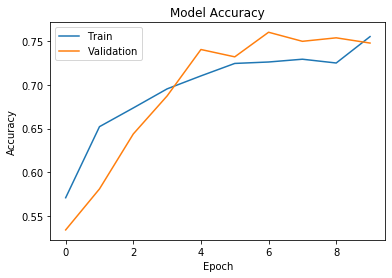

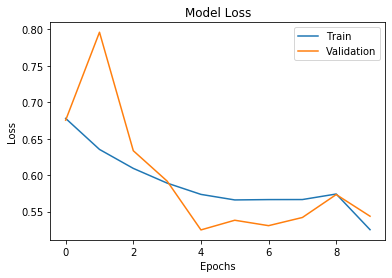

In [74]:
# accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()
# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

In [0]:
#loading previously saved model from drive.
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
#model = tf.keras.models.load_model("/content/drive/My Drive/catvsdog-64x3v2.model")
model.summary()

In [0]:
X_test,_ = prep_images(test_images)

In [0]:
X_test = np.array(X_test).astype('float32')
X_test = X_test/255

In [76]:
predictions = model.predict(X_test, verbose=1)

12500/12500 [==============================] - 3s 271us/sample


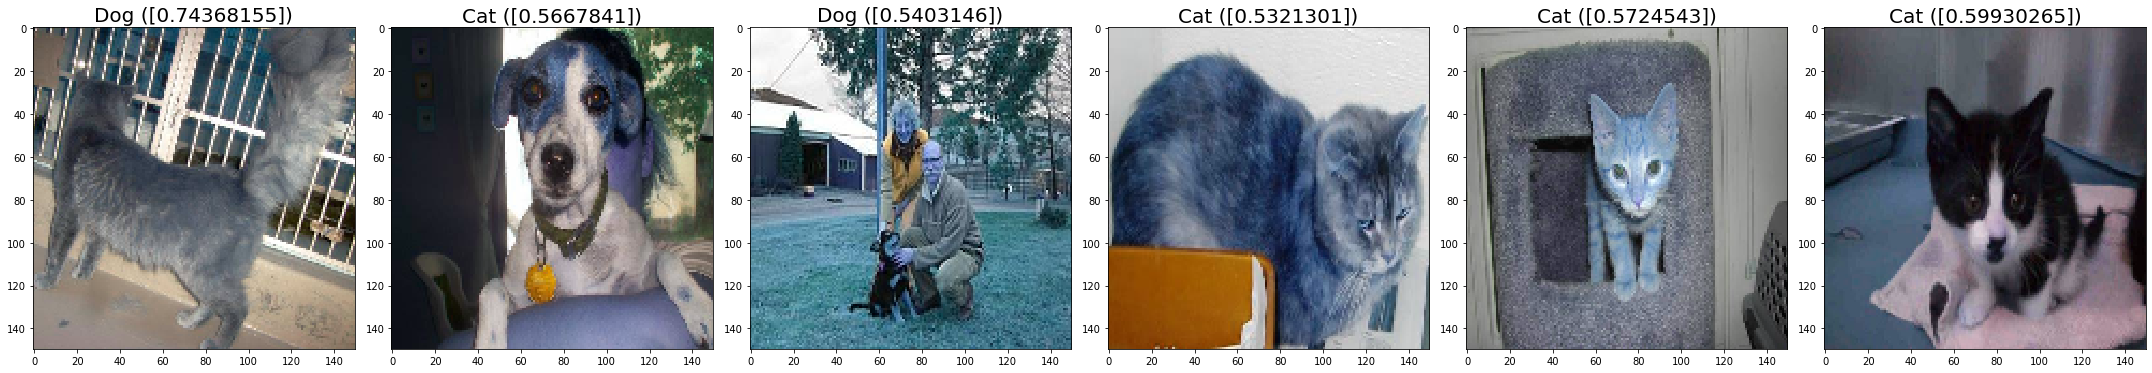

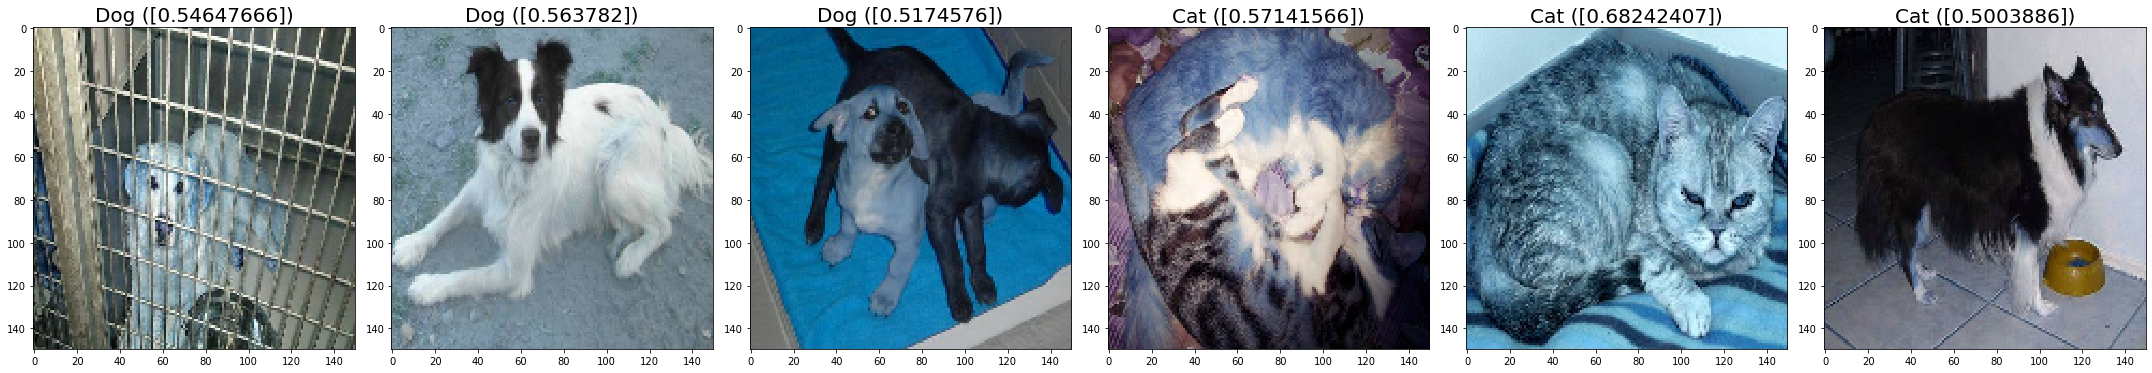

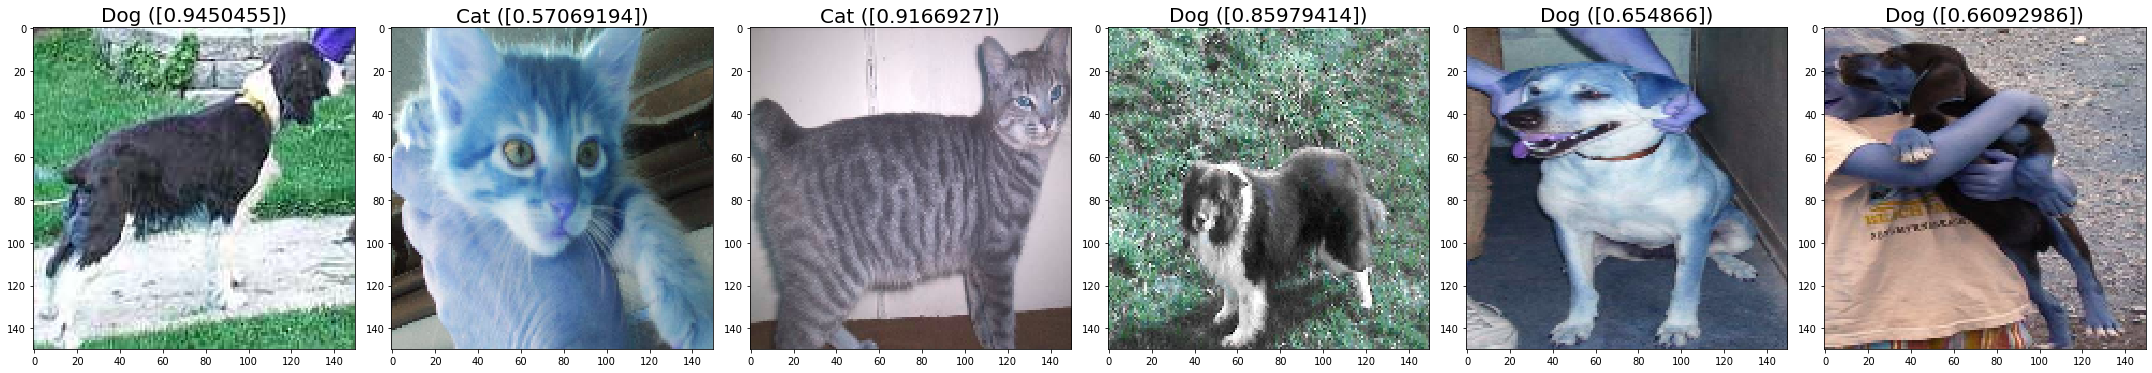

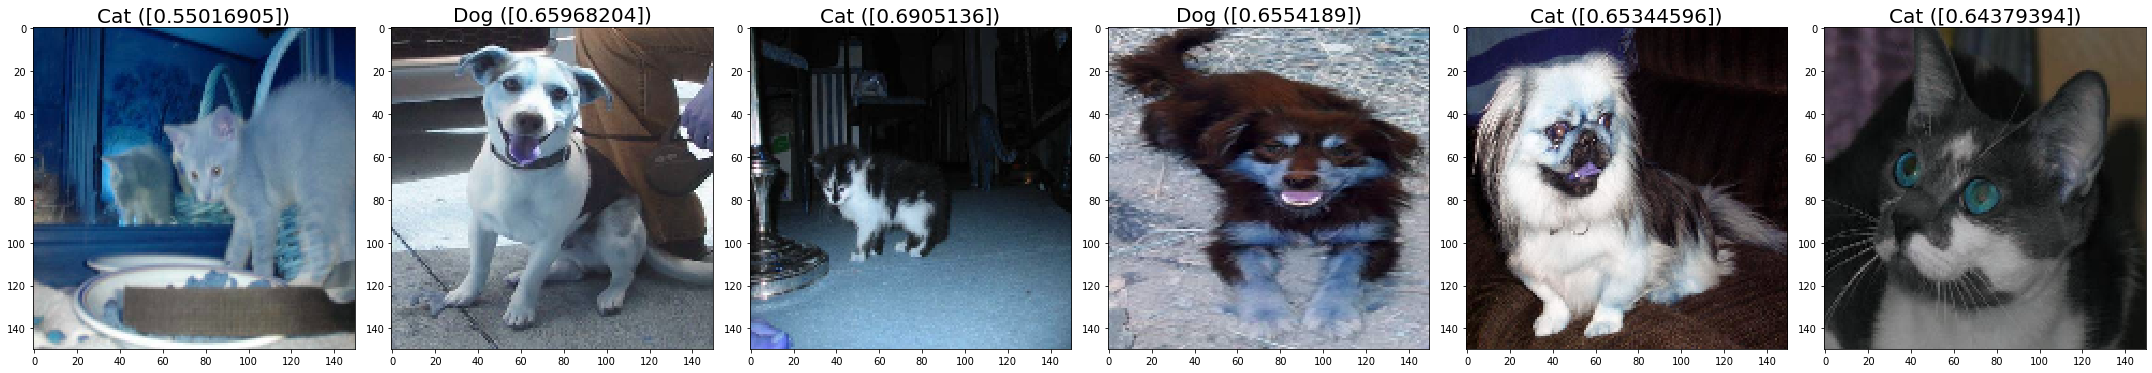

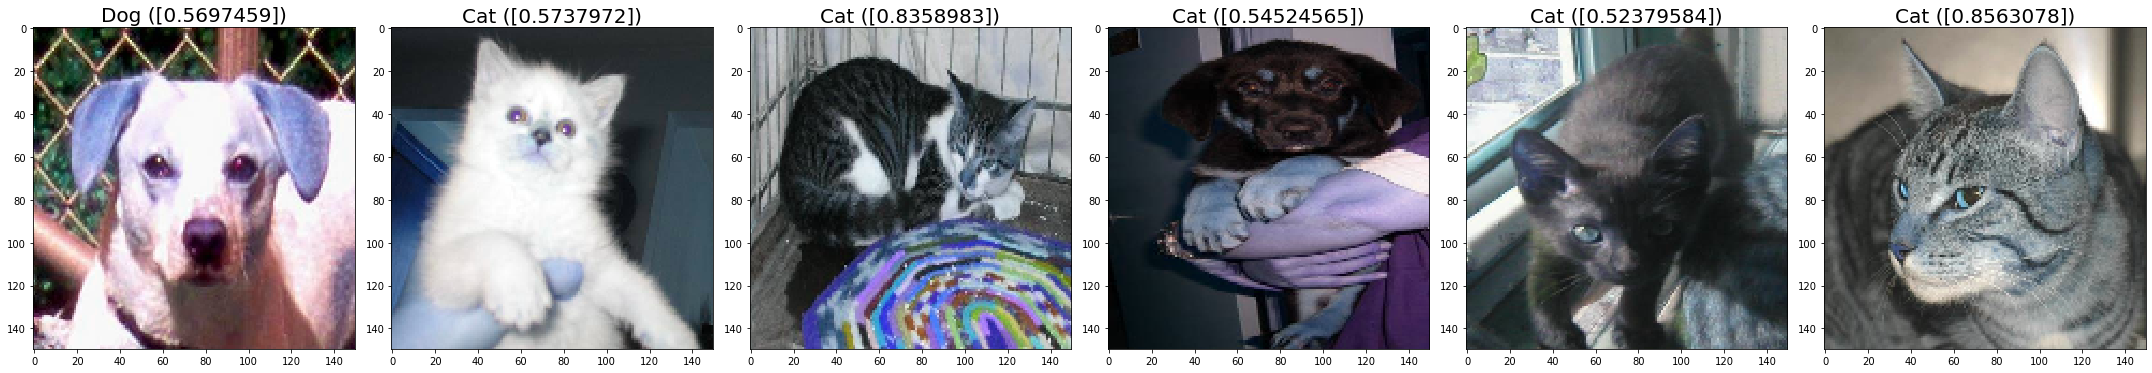

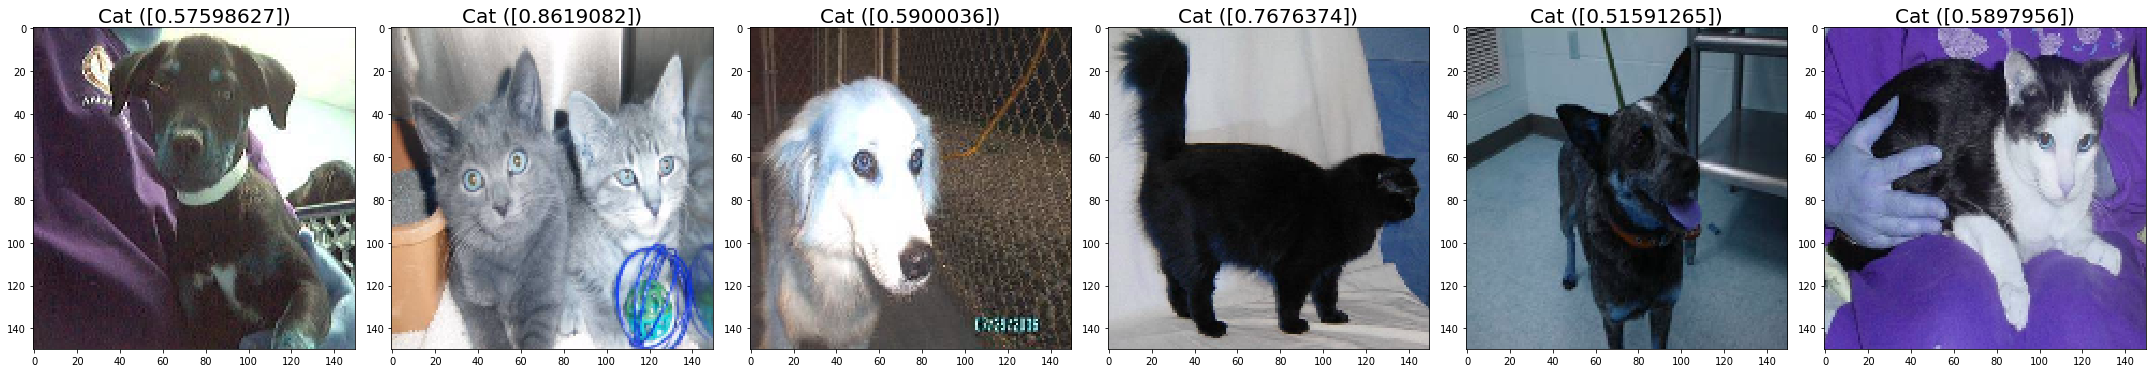

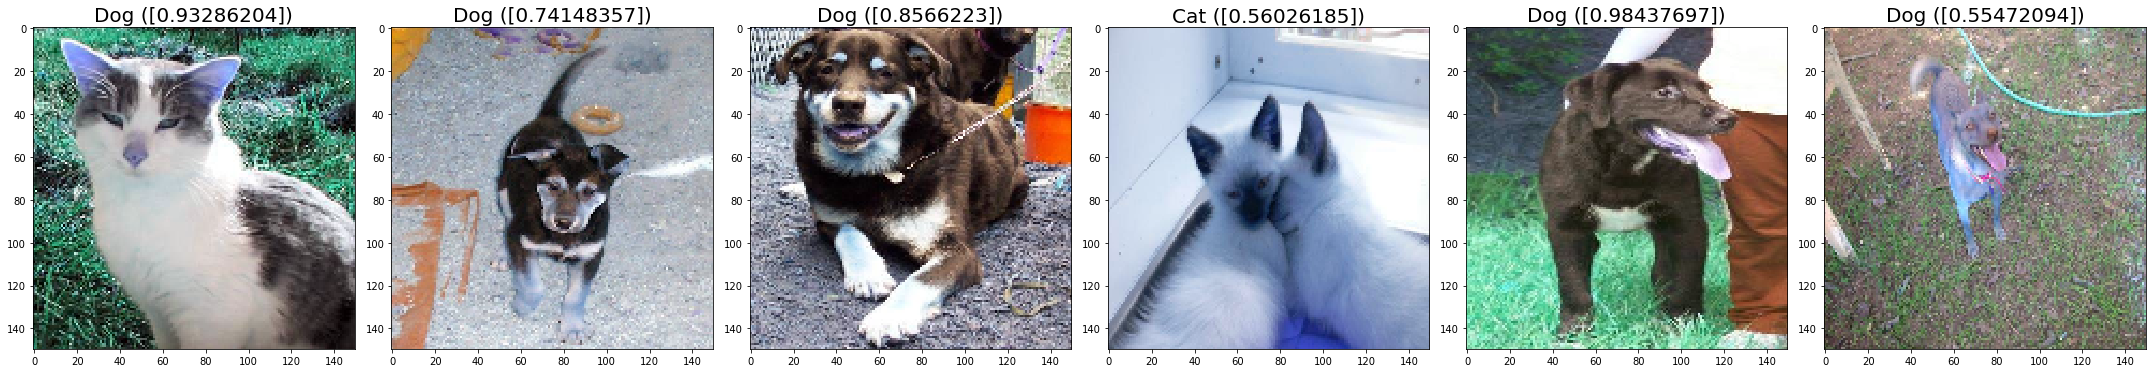

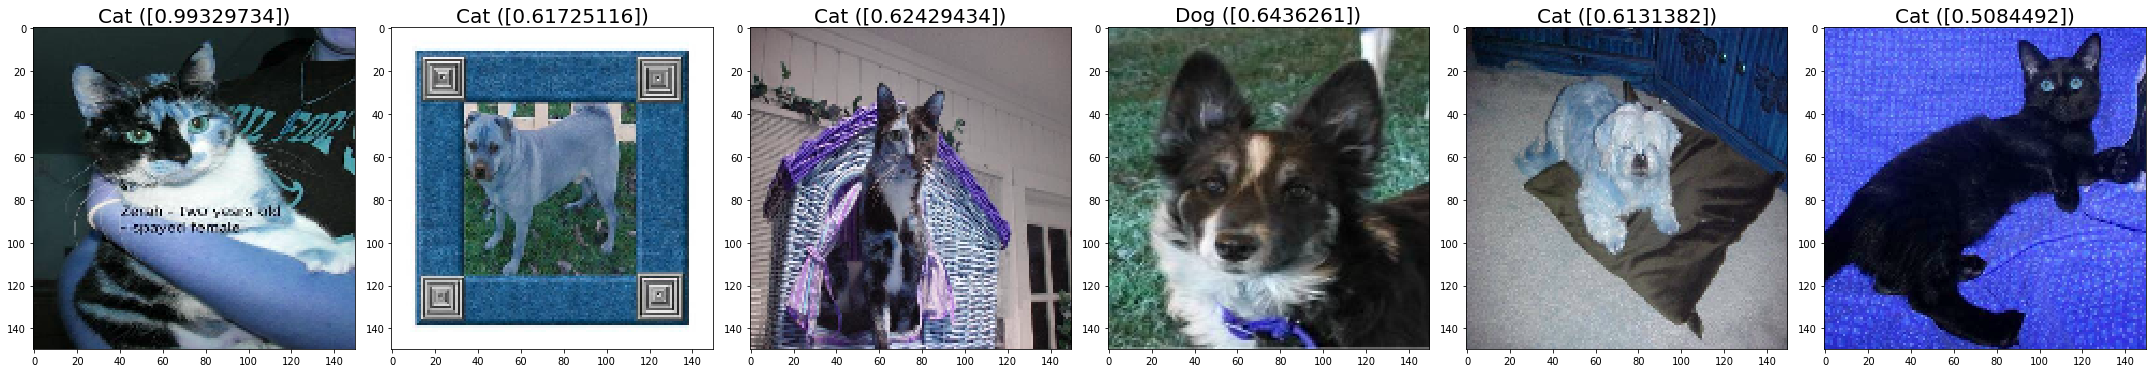

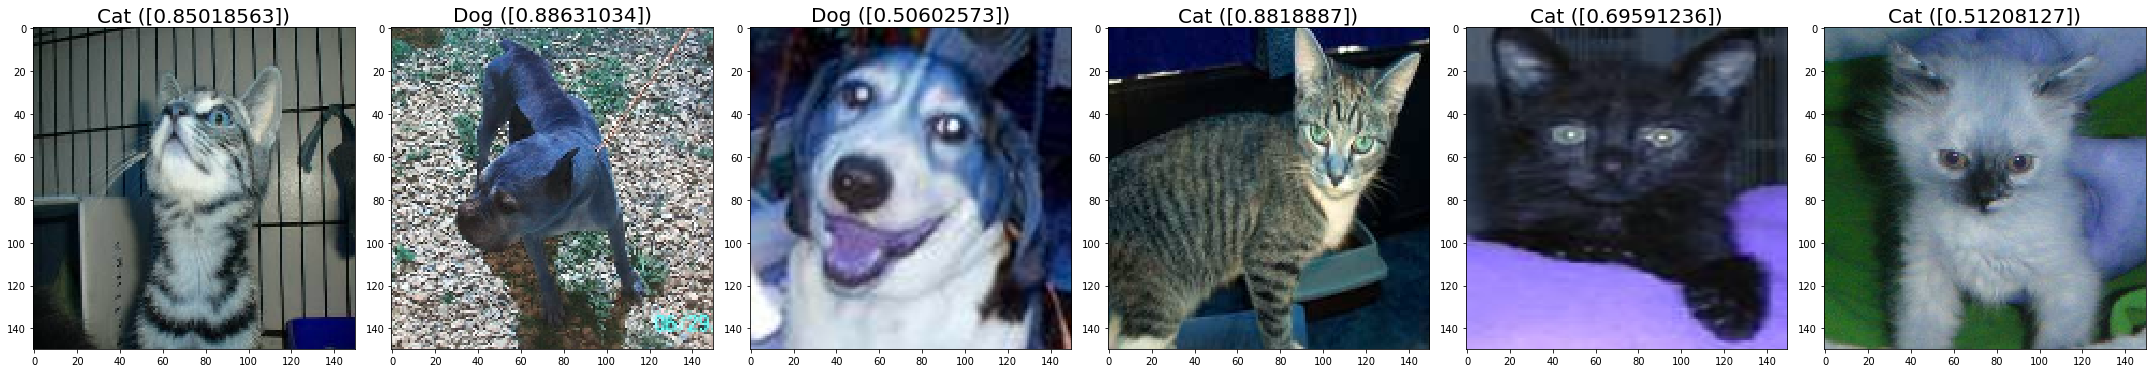

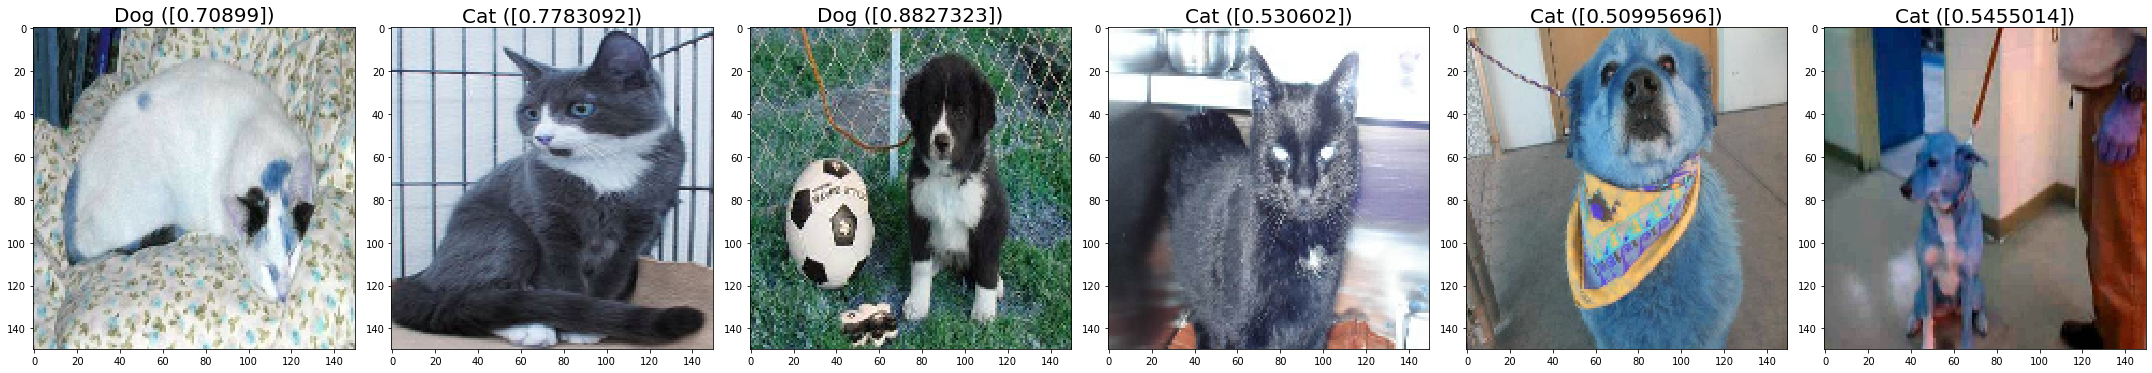

In [77]:
for i in range(0, 60, 6): 
    plot_data(X_test[i:], predictions[i:], 6)